In [1]:
import os
import shutil
import sys
import pathlib
from datetime import datetime

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import torch
import wandb

from src.attrs import PATHS
from src.models import cnn
from src import utils

torch.set_grad_enabled(False);

~/.conda/envs/koopman/lib/python3.11/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
plt.style.use('bmh')

In [3]:
SUBPROJECT = 'cnn_north_atlantic_daily_subsampled'

ckpt = torch.load(
    os.path.join(PATHS['networks'], SUBPROJECT, 'kae_ssh.20', f'last-v1.ckpt'),
    map_location='cpu'
)
state_dict = ckpt['state_dict']
B = state_dict['linear_embedding.weight']
eigs = linalg.eig(B)[0]

In [4]:
ckpt['epoch']

499

In [5]:
np.sort(eigs.real**2 + eigs.imag**2)

array([0.07186854, 0.07186854, 0.08886478, 0.1334792 , 0.1736852 ,
       0.1736852 , 0.22215077, 0.2935707 , 0.43975678, 0.43975678,
       0.6331643 , 0.6768379 , 0.6768379 , 0.7443187 , 0.87102264,
       0.87102264, 0.8722078 , 0.9642373 , 0.9871834 , 1.0068426 ],
      dtype=float32)

In [10]:
api = wandb.Api()
# run = api.run('andrewbrettin/koopman_autoencoders/ticjzxym')
run = api.run('andrewbrettin/koopman_autoencoders/7ds5es1a')

df = run.history()
df = df.groupby('epoch').mean()
best_preds = df.sort_values('val/prediction_mse').head(50).sort_values('epoch')

eig_reals = np.zeros((50,20))
eig_imags = np.zeros((50,20))

for i, epoch in enumerate(best_preds.index):
    try:
        # State dict
        state_dict = torch.load(
            os.path.join(PATHS['networks'], SUBPROJECT, 'kae_ssh.20', f'best_pred-epoch={epoch}.ckpt'),
            map_location='cpu'
        )['state_dict']
        B = state_dict['linear_embedding.weight']
        
        # Eigenvalues
        eigs = linalg.eig(B)[0]
        eig_norms = np.sort(np.sqrt(eigs.real**2 + eigs.imag**2))
        eig_reals[i,:] = eigs.real
        eig_imags[i,:] = eigs.imag
    except:
        pass

In [11]:
len(best_preds.index)

50

Text(0, 0.5, 'Eigenvalue')

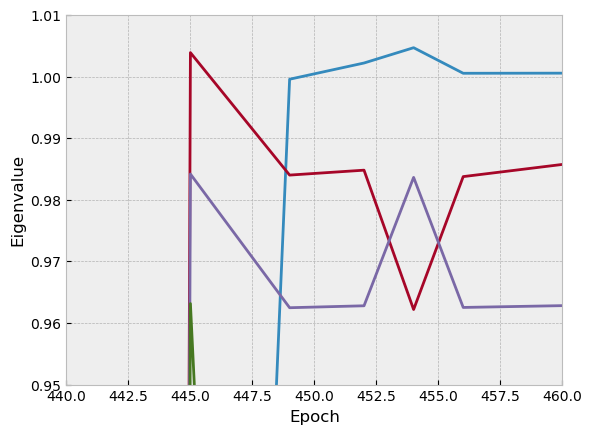

In [12]:
plt.plot(best_preds.index, eig_reals**2 + eig_imags**2)
plt.xlim(440, 460)
plt.ylim(0.95,1.01)
plt.xlabel('Epoch')
plt.ylabel('Eigenvalue')

Text(0, 0.5, 'Eigenvalue')

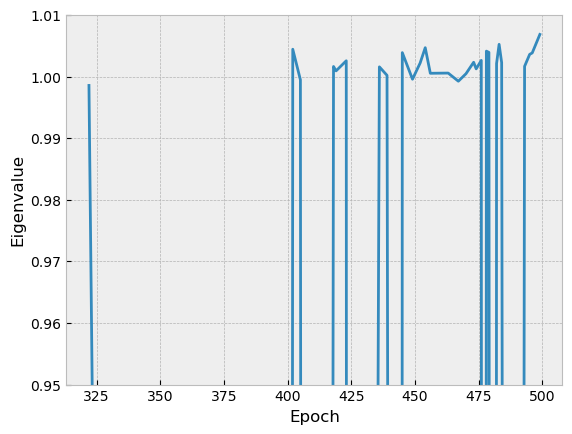

In [16]:
plt.plot(best_preds.index, np.max(eig_reals**2 + eig_imags**2, axis=1))
plt.ylim(0.95,1.01)
plt.xlabel('Epoch')
plt.ylabel('Eigenvalue')

In [17]:
REGION = 'north_atlantic'
SAMPLING = 'daily_subsampled'
N_LATENTS = 20

SUBPROJECT = f'cnn_{REGION}_{SAMPLING}'
EXPERIMENT = 'kae_ssh'
MODEL_NAME = f"{SUBPROJECT}/{EXPERIMENT}.{N_LATENTS}_A"
MODEL_PATH = os.path.join(PATHS['networks'], MODEL_NAME)
DATA_PATH = PATHS[SUBPROJECT]

configs = utils.load_configs(EXPERIMENT)
configs['H'] = 64  # 80, 64
configs['W'] = 96  # 144, 96
configs['l2'] = 0.01 # 0.001
configs['D'] = 20
configs['weights'] = torch.load(os.path.join(PATHS[SUBPROJECT], 'weights.pt'))

In [18]:
best_preds = df.sort_values('val/prediction_mse').head(20)
best_preds

for i, epoch in enumerate(best_preds.index):
    try:
        # State dict
        state_dict = torch.load(
            os.path.join(PATHS['networks'], SUBPROJECT, 'kae_ssh.20', f'best_pred-epoch={epoch}.ckpt'),
            map_location='cpu'
        )['state_dict']
        B = state_dict['linear_embedding.weight']
        eigs = linalg.eig(B)[0]
        eig_norms = eigs.real**2 + eigs.imag**2

        if eig_norms.max() <= 1:
            print(epoch)
            print(eig_norms.max())

            # Save model
            # model = cnn.CNNKoopmanAutoencoder(configs)
            # model.load_state_dict(state_dict)
            # model.save(
            #     model_path=MODEL_PATH,
            #     name=MODEL_NAME,
            #     date=datetime.now(),
            #     data_path=os.path.join(DATA_PATH, 'multipass'),
            # )
            
    except:
        pass

449
0.999571
467
0.9992503


In [61]:
np.sort(eig_norms)

array([0.08553268, 0.08553268, 0.09030642, 0.14774986, 0.18426894,
       0.18426894, 0.23162559, 0.27070934, 0.3413518 , 0.3413518 ,
       0.6174614 , 0.6921309 , 0.69500685, 0.69500685, 0.8416043 ,
       0.8416043 , 0.86380017, 0.9581983 , 0.9809414 , 1.0021446 ],
      dtype=float32)

**Save model with valid propagator weights**

In [19]:
REGION = 'north_atlantic'
SAMPLING = 'daily_subsampled'
N_LATENTS = 20

SUBPROJECT = f'cnn_{REGION}_{SAMPLING}'
EXPERIMENT = 'kae_ssh'
MODEL_NAME = f"{SUBPROJECT}/{EXPERIMENT}.{N_LATENTS}"
MODEL_PATH = os.path.join(PATHS['networks'], MODEL_NAME)
DATA_PATH = PATHS[SUBPROJECT]

configs = utils.load_configs(EXPERIMENT)
configs['H'] = 64  # 80, 64
configs['W'] = 96  # 144, 96
configs['l2'] = 0.01 # 0.001
configs['D'] = 20
configs['weights'] = torch.load(os.path.join(PATHS[SUBPROJECT], 'weights.pt'))

model = cnn.CNNKoopmanAutoencoder(configs)

# Load weights from checkpoint
ckpt = torch.load(
    os.path.join(PATHS['networks'], SUBPROJECT, 'kae_ssh.20', f'last_valid.ckpt'),
    map_location='cpu'
)
state_dict = ckpt['state_dict']
model.load_state_dict(state_dict)

model.save(
    model_path=MODEL_PATH,
    name=MODEL_NAME,
    date=datetime.now(),
    data_path=os.path.join(DATA_PATH, 'multipass'),
)

---

Checkpoint 343

In [20]:
ckpt = torch.load(
    os.path.join(PATHS['networks'], SUBPROJECT, 'kae_ssh.20', f'best_pred-epoch=467.ckpt'),
    map_location='cpu'
)

state_dict = ckpt['state_dict']
B = state_dict['linear_embedding.weight']
eigs = linalg.eig(B)[0]

print(ckpt['epoch'])
np.sort(eigs.real**2 + eigs.imag**2)

467


array([0.0740861 , 0.0740861 , 0.08900437, 0.13677406, 0.17755766,
       0.17755766, 0.22107145, 0.2872137 , 0.41113254, 0.41113254,
       0.62954074, 0.68349236, 0.68349236, 0.7259756 , 0.865207  ,
       0.865207  , 0.8655382 , 0.96323305, 0.98601496, 0.9992503 ],
      dtype=float32)

In [21]:
torch.save(ckpt,
    os.path.join(PATHS['networks'], SUBPROJECT, 'kae_ssh.20', f'last_valid.ckpt'),
)

In [22]:
REGION = 'north_atlantic'
SAMPLING = 'daily_subsampled'
N_LATENTS = 20

SUBPROJECT = f'cnn_{REGION}_{SAMPLING}'
EXPERIMENT = 'kae_ssh'
MODEL_NAME = f"{SUBPROJECT}/{EXPERIMENT}.{N_LATENTS}"
MODEL_PATH = os.path.join(PATHS['networks'], MODEL_NAME)
DATA_PATH = PATHS[SUBPROJECT]

configs = utils.load_configs(EXPERIMENT)
configs['H'] = 64  # 80, 64
configs['W'] = 96  # 144, 96
configs['l2'] = 0.01 # 0.001
configs['D'] = 20
configs['weights'] = torch.load(os.path.join(PATHS[SUBPROJECT], 'weights.pt'))

model = cnn.CNNKoopmanAutoencoder(configs)

# Load weights from checkpoint
ckpt = torch.load(
    os.path.join(PATHS['networks'], SUBPROJECT, 'kae_ssh.20', f'last_valid.ckpt'),
    map_location='cpu'
)
state_dict = ckpt['state_dict']
model.load_state_dict(state_dict)

model.save(
    model_path=MODEL_PATH,
    name=MODEL_NAME,
    date=datetime.now(),
    data_path=os.path.join(DATA_PATH, 'multipass'),
)